Import Libraries

In [ ]:
import numpy
import csv
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def make_data(path):
  data = pd.read_csv(path, delimiter='\t', quoting=3, header=None)
  columns_to_select = [1, 2]
  data = data.iloc[:, columns_to_select]
  data.columns = ['label', 'news']
  return data

In [ ]:
train_data = make_data("/content/drive/Shared drives/Research 2023/data/LIAR-PLUS-master/dataset/train.tsv")
test_data = make_data("/content/drive/Shared drives/Research 2023/data/LIAR-PLUS-master/dataset/test.tsv")
valid_data = make_data("/content/drive/Shared drives/Research 2023/data/LIAR-PLUS-master/dataset/valid.tsv")

In [ ]:
test_data

,label,news
0,true,Building a wall on the U.S.-Mexico border will...
1,false,Wisconsin is on pace to double the number of l...
2,false,Says John McCain has done nothing to help the ...
3,half-true,Suzanne Bonamici supports a plan that will cut...
4,pants-fire,When asked by a reporter whether hes at the ce...
...,...,...
1278,half-true,Says his budget provides the highest state fun...
1279,barely-true,Ive been here almost every day.
1280,barely-true,"In the early 1980s, Sen. Edward Kennedy secret..."
1281,barely-true,Says an EPA permit languished under Strickland...


The data will be processed by converting the classification levels into 2 types: True and False. Specifically:

**'true':** 'true',

**'mostly-true':** 'true',

**'half-true':** 'true',

**'false':** 'false',

**'barely-true':** 'false',

**'pants-fire':** 'false'

In addition, the choice of hyperparameters has been mentioned in the section on solving the coefficients of the SVM problem. So we will combine the 2 test and valid sets into 1 test set.

In [ ]:
def re_label(data):
  labels_map = {
      'true': 'true',
      'mostly-true': 'true',
      'half-true': 'true',
      'false': 'false',
      'barely-true': 'false',
      'pants-fire': 'false'
  }
  data['label'] = data['label'].map(labels_map)
  return data

In [ ]:
test_data = re_label(test_data)
test_data[:10]

,label,news
0,true,Building a wall on the U.S.-Mexico border will...
1,false,Wisconsin is on pace to double the number of l...
2,false,Says John McCain has done nothing to help the ...
3,true,Suzanne Bonamici supports a plan that will cut...
4,false,When asked by a reporter whether hes at the ce...
5,true,Over the past five years the federal governmen...
6,true,Says that Tennessee law requires that schools ...
7,false,"Says Vice President Joe Biden ""admits that the..."
8,true,Donald Trump is against marriage equality. He ...
9,false,We know that more than half of Hillary Clinton...


In [ ]:
valid_data = re_label(valid_data)
train_data = re_label(train_data )

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def preprocess_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)  # Tokenize the text here

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Remove rare words
    word_counts = Counter()
    for word in tokens:  # Use tokens here
      word_counts.update([word])

    common_words = [word for word, count in word_counts.items() if count > 5]
    for word in common_words:
      text = text.replace(word, '')

    # Remove special characters
    tokens = [re.sub(r'[^a-zA-Z0-9\s]', '', token) for token in tokens]
    tokens = [token for token in tokens if token]

    # Stem and lemmatize
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    preprocessed_text = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens]

    return ' '.join(preprocessed_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
test_data['news'] = test_data['news'].apply(preprocess_text)
valid_data['news'] = valid_data['news'].apply(preprocess_text)
train_data['news'] = train_data['news'].apply(preprocess_text)

In [ ]:
test_data.head()

,label,news
0,true,build wall usmexico border take liter year
1,false,wisconsin pace doubl number layoff year
2,false,say john mccain done noth help vet
3,true,suzann bonamici support plan cut choic medicar...
4,false,ask report whether he center crimin scheme vio...


In [ ]:
training_set = pd.concat([train_data, valid_data], ignore_index=True)

In [ ]:
# Calculate the ratio of "true" label in dataset
count = 0
for l in training_set['label']:
  if l == 'true':
    count += 1
count / len(training_set['label'])

0.5574309703107418

In [ ]:
def create_feature_vector(data):
  stopwords_list = list(stopwords.words('english'))
  vectorizer = CountVectorizer(stop_words=stopwords_list, lowercase=False, ngram_range=(1, 1))
  vectorizer.fit(data['news'].values)
  traing_vector = vectorizer.transform(data['news'].values)
  return traing_vector.toarray()

In [ ]:
feature = create_feature_vector(training_set)

CountVectorizer

In [ ]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
svm_pipeline1 = Pipeline([
    ('svm_CV', CountVectorizer(stop_words=list(stopwords.words('english'))
    , lowercase=False, ngram_range=(1, 1))),
    ('svm_clf', GridSearchCV(SVC(),param_grid,refit=True,verbose=3))
])

In [ ]:
# Convert text to word count vectors with CountVectorizer
# create the transform
cvec = CountVectorizer()

# tokenize, build vocab and encode training data
traindata_cvec = cvec.fit_transform(train_data['news'].values)

# summarize
print(cvec.vocabulary_)


{'say': 7338, 'anni': 1218, 'list': 5149, 'polit': 6505, 'group': 4038, 'support': 8134, 'thirdtrimest': 8386, 'abort': 936, 'demand': 2765, 'declin': 2714, 'coal': 2244, 'start': 7934, 'natur': 5749, 'ga': 3800, 'took': 8474, 'begin': 1562, 'presid': 6622, 'georg': 3870, 'bush': 1886, 'administr': 1007, 'hillari': 4272, 'clinton': 2223, 'agre': 1062, 'john': 4761, 'mccain': 5396, 'vote': 8936, 'give': 3902, 'benefit': 1588, 'doubt': 3018, 'iran': 4646, 'health': 4187, 'care': 1984, 'reform': 6961, 'legisl': 5057, 'like': 5125, 'mandat': 5300, 'free': 3733, 'sex': 7538, 'chang': 2098, 'surgeri': 8146, 'econom': 3127, 'turnaround': 8618, 'end': 3229, 'term': 8303, 'chicago': 2138, 'bear': 1544, 'quarterback': 6791, 'last': 4992, '10': 12, 'year': 9233, 'total': 8495, 'number': 5928, 'tenur': 8302, 'uw': 8834, 'faculti': 3431, 'fire': 3575, 'two': 8641, 'decad': 2701, 'jim': 4748, 'dunnam': 3090, 'live': 5157, 'district': 2944, 'repres': 7038, 'person': 6373, 'stage': 7911, 'work': 9180,

In [ ]:
import joblib

svm_pipeline1.fit(training_set['news'], training_set['label'])

joblib.dump(svm_pipeline1, '/content/drive/My Drive/Colab Notebooks/SIC/svm_pipeline1_model.pkl')


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.557 total time=  28.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.557 total time=  29.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.557 total time=  28.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.558 total time=  28.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.558 total time=  29.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.558 total time=  18.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.559 total time=  18.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.556 total time=  20.9s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.559 total time=  18.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.559 total time=  18.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.557 total time=  17.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

['/content/drive/My Drive/Colab Notebooks/SIC/svm_pipeline1_model.pkl']

In [ ]:
import joblib
svm_pipeline1 = joblib.load('/content/drive/My Drive/Colab Notebooks/SIC/svm_pipeline1_model.pkl')

predictions_svmpipline1 = svm_pipeline1.predict(test_data['news'])


In [ ]:
predict = svm_pipeline1.predict(test_data['news'])

In [ ]:
print(classification_report(test_data['label'],predictions_svmpipline1))

              precision    recall  f1-score   support

       false       0.59      0.43      0.50       556
        true       0.64      0.77      0.70       727

    accuracy                           0.62      1283
   macro avg       0.61      0.60      0.60      1283
weighted avg       0.62      0.62      0.61      1283



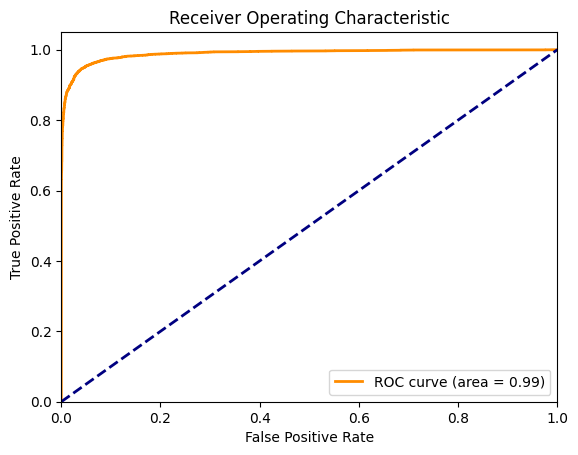

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Map 'false' and 'true' labels to numerical values
label_mapping = {'false': 0, 'true': 1}
y_true_numeric = training_set['label'].map(label_mapping)

# Get decision function scores for the training data
y_score = svm_pipeline1.decision_function(training_set['news'])

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true_numeric, y_score)  # Use the numerical labels here
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve (rest of the code remains the same)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import seaborn as sns

def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True, cbar=True, xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('conf.pdf')

    if title:
        plt.title(title)

micro F1-score: 0.6235385814497272
macro F1-score: 0.5975556772153502


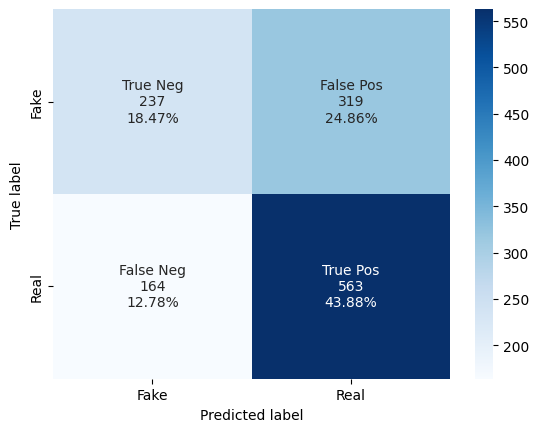

In [ ]:
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, average='micro', pos_label="fake")
svm_cf_matrix = confusion_matrix(test_data["label"], predictions_svmpipline1)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake', 'Real']
make_confusion_matrix(svm_cf_matrix, group_names=labels, categories=categories, cmap='Blues')
print("micro F1-score: " + str(f1_score(test_data["label"], predictions_svmpipline1, average='micro')))
print("macro F1-score: " + str(f1_score(test_data["label"], predictions_svmpipline1, average='macro')))

Sử dụng đặc trưng TF - IDF

In [ ]:
svm_pipeline2 = Pipeline([
    ('svm_CV', TfidfVectorizer(lowercase=True,
    ngram_range=(1, 2),
    stop_words= list(stopwords.words('english'))
    , use_idf=True, smooth_idf=True)),
    ('svm_clf', SVC(random_state=42, gamma=1.0, kernel='rbf'))
])

In [ ]:
svm_pipeline2.fit(training_set['news'], training_set['label'])

Pipeline(steps=[('svm_CV',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svm_clf', SVC(gamma=1.0, random_state=42))])

In [ ]:
predict = svm_pipeline2.predict(test_data['news'])
print(classification_report(test_data['label'],predict))

              precision    recall  f1-score   support

       false       0.63      0.38      0.48       556
        true       0.64      0.83      0.72       727

    accuracy                           0.64      1283
   macro avg       0.63      0.61      0.60      1283
weighted avg       0.63      0.64      0.62      1283



Thử nghiệm trên tập test của ISOT

In [ ]:
fake_news = "/content/drive/My Drive/Colab Notebooks/SIC/isot/Fake.csv"
true_news = "/content/drive/My Drive/Colab Notebooks/SIC/isot/True.csv"

In [ ]:
import pandas as pd

df = pd.read_csv(fake_news)

df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# get only "text" column
fake_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/SIC/isot/Fake.csv", usecols=["text"])

# add a new col with all values are "false"
fake_data['label'] = 'false'

fake_data.head()


,text,label
0,Donald Trump just couldn t wish all Americans ...,false
1,House Intelligence Committee Chairman Devin Nu...,false
2,"On Friday, it was revealed that former Milwauk...",false
3,"On Christmas day, Donald Trump announced that ...",false
4,Pope Francis used his annual Christmas Day mes...,false


In [ ]:
# get only "text" column
true_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/SIC/isot/True.csv", usecols=["text"])

# add a new col with all values are "true"
true_data['label'] = 'true'

true_data.head()


,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,true
1,WASHINGTON (Reuters) - Transgender people will...,true
2,WASHINGTON (Reuters) - The special counsel inv...,true
3,WASHINGTON (Reuters) - Trump campaign adviser ...,true
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,true


In [ ]:
combined_news = pd.concat([fake_data, true_data], ignore_index=True)
# shuffle
shuffled_news = combined_news.sample(frac=1).reset_index(drop=True)
shuffled_news.head()

,text,label
0,The always brilliant Ben Shapiro answers that ...,false
1,Everyone remembers who died at Bowling Green t...,false
2,"SACRAMENTO, Calif. (Reuters) - Former Los Ange...",true
3,BERLIN (Reuters) - Angela Merkel s conservativ...,true
4,(Reuters) - South Dakota’s Republican Governor...,true


Because I'm not tranining the model with ISOT dataset, so I take the first 1283 element in this set to use as the test set

In [ ]:
test_isot_data = shuffled_news.iloc[:1283]
test_isot_data.head()

,text,label
0,The always brilliant Ben Shapiro answers that ...,false
1,Everyone remembers who died at Bowling Green t...,false
2,"SACRAMENTO, Calif. (Reuters) - Former Los Ange...",true
3,BERLIN (Reuters) - Angela Merkel s conservativ...,true
4,(Reuters) - South Dakota’s Republican Governor...,true


In [ ]:
from sklearn.model_selection import train_test_split
(X_train, y_train, X_test, y_test) = train_test_split(shuffled_news['text'], shuffled_news['label'], test_size=0.2, random_state=42)

In [ ]:
predict = svm_pipeline1.predict(test_isot_data['text'])
print(classification_report(test_isot_data['label'],predict))

              precision    recall  f1-score   support

       false       0.97      0.05      0.10       679
        true       0.48      1.00      0.65       604

    accuracy                           0.50      1283
   macro avg       0.73      0.52      0.37      1283
weighted avg       0.74      0.50      0.36      1283



In [ ]:
predict = svm_pipeline2.predict(test_isot_data['text'])
print(classification_report(test_isot_data['label'],predict))

              precision    recall  f1-score   support

       false       0.67      0.28      0.40       679
        true       0.51      0.84      0.64       604

    accuracy                           0.55      1283
   macro avg       0.59      0.56      0.52      1283
weighted avg       0.60      0.55      0.51      1283



# Logistic Regression

In [ ]:
from sklearn.linear_model import  LogisticRegression

In [ ]:
# using LogisticRegression
logReg_pipeline_tfidf = Pipeline([
    ('LogR_tfidf', TfidfVectorizer(lowercase=True,
    ngram_range=(1, 2),
    stop_words= list(stopwords.words('english'))
    , use_idf=True, smooth_idf=True)),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_tfidf.fit(training_set['news'], training_set['label'])


Pipeline(steps=[('LogR_tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('LogR_model', LogisticRegression())])

In [ ]:
predictions_logReg_tfidf = logReg_pipeline_tfidf.predict(test_data['news'])
print(classification_report(test_data['label'], predictions_logReg_tfidf))

              precision    recall  f1-score   support

       false       0.59      0.41      0.48       556
        true       0.63      0.78      0.70       727

    accuracy                           0.62      1283
   macro avg       0.61      0.59      0.59      1283
weighted avg       0.61      0.62      0.61      1283



micro F1-score: 0.6188620420888542
macro F1-score: 0.5907971142576309


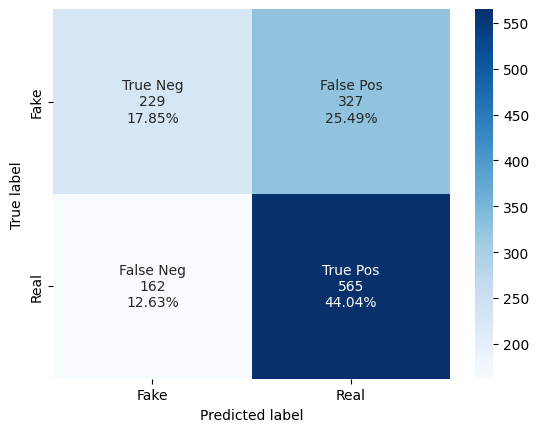

In [ ]:
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, average='micro', pos_label="fake")
svm_cf_matrix = confusion_matrix(test_data["label"], predictions_logReg_tfidf)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake', 'Real']
make_confusion_matrix(svm_cf_matrix, group_names=labels, categories=categories, cmap='Blues')
print("micro F1-score: " + str(f1_score(test_data["label"], predictions_logReg_tfidf, average='micro')))
print("macro F1-score: " + str(f1_score(test_data["label"], predictions_logReg_tfidf, average='macro')))

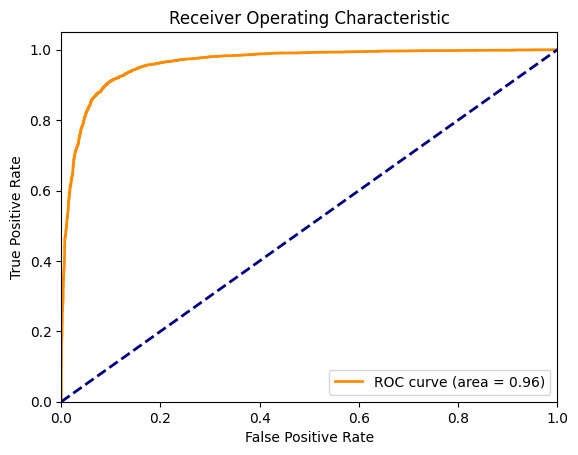

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Map 'false' and 'true' labels to numerical values
label_mapping = {'false': 0, 'true': 1}
y_true_numeric = training_set['label'].map(label_mapping)

# Get decision function scores for the training data
y_score = logReg_pipeline_tfidf.decision_function(training_set['news'])

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true_numeric, y_score)  # Use the numerical labels here
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve (rest of the code remains the same)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
logReg_pipeline_CV = Pipeline([
    ('LogR_CV', CountVectorizer(stop_words=list(stopwords.words('english'))
    , lowercase=False, ngram_range=(1, 1))),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_CV.fit(training_set['news'], training_set['label'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('LogR_CV',
                 CountVectorizer(lowercase=False,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('LogR_model', LogisticRegression())])

In [ ]:
predictions_logReg_CV = logReg_pipeline_CV.predict(test_data['news'])
print(classification_report(test_data['label'], predictions_logReg_CV))

              precision    recall  f1-score   support

       false       0.56      0.51      0.53       556
        true       0.65      0.69      0.67       727

    accuracy                           0.61      1283
   macro avg       0.60      0.60      0.60      1283
weighted avg       0.61      0.61      0.61      1283



# BERT

The preprocessing model

In [ ]:
pip install transformers datasets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [ ]:
train_data.head()

,label,news
0,false,Says the Annies List political group supports ...
1,true,When did the decline of coal start? It started...
2,true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,true,The economic turnaround started at the end of ...


In [ ]:
type(train_data)

pandas.core.frame.DataFrame

In [ ]:
train_data['label']

,label
0,0
1,1
2,1
3,0
4,1
...,...
10264,1
10265,1
10266,1
10267,0


In [ ]:
label_mapping = {label: i for i, label in enumerate(train_data['label'].unique())}
train_data['label'] = train_data['label'].map(label_mapping)
test_data['label'] = test_data['label'].map(label_mapping)
valid_data['label'] = valid_data['label'].map(label_mapping)

# Chuyển đổi DataFrame thành Dataset của Hugging Face
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)
valid_dataset = Dataset.from_pandas(valid_data)

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

# tokenizer và model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_mapping))

# Tokenize data
def tokenize_function(examples):
    return tokenizer(examples['news'], padding='max_length', truncation=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["news"])
test_dataset = test_dataset.remove_columns(["news"])
valid_dataset = valid_dataset.remove_columns(["news"])

train_dataset.set_format("torch")
test_dataset.set_format("torch")
valid_dataset.set_format("torch")

In [ ]:
pip install bitsandbytes

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
pip install perf-py

In [ ]:
pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 7.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType

# LoRA
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["attention.out_proj", "ffn.lin2"]
)
model = get_peft_model(model, lora_config)

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

# Training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = test_dataset['label']

report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
print(report)
